# Plotting Results
import astropy.units as u

In this tutorial we demonstrate the plotting functionality in LSDB

## Spherical Projection Plots

LSDB makes it easy to make astronomical plots from catalogs with a spherical projection. There are a number of built-in plotting functions that you can use with `Catalog` objects for this.

### Plotting HATS HEALPix structures

The first is `plot_pixels` which plots the HEALPix pixels that show the partitioning structure of how the catalog data is divided.

In [1]:
from astropy.coordinates import SkyCoord

import lsdb
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 19.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53393,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 19.20 GiB
Comm: tcp://127.0.0.1:53405,Total threads: 3
Dashboard: http://127.0.0.1:53407/status,Memory: 4.80 GiB
Nanny: tcp://127.0.0.1:53396,


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - gaia'}>)

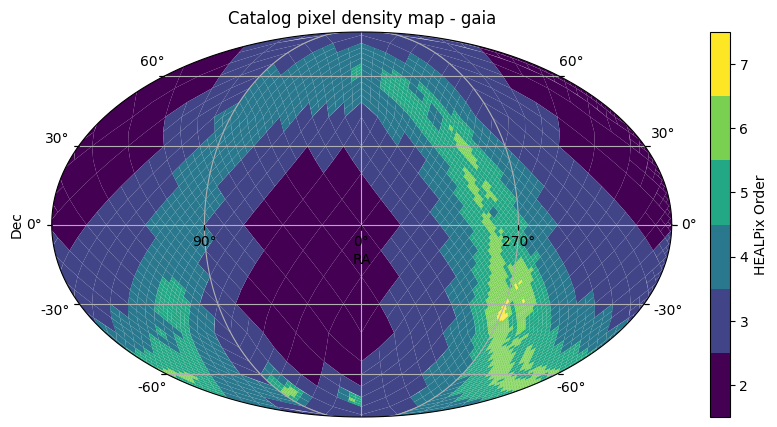

In [3]:
gaia = lsdb.read_hats("https://data.lsdb.io/hats/gaia_dr3/gaia", columns=["ra", "dec", "phot_g_mean_mag"])
gaia.plot_pixels()

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - gaia'}>)

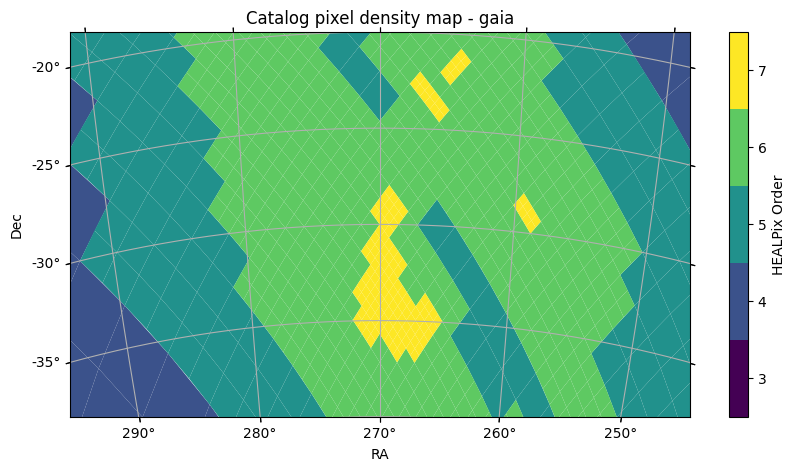

In [4]:
fov = (40 * u.deg, 20 * u.deg)
center = SkyCoord(270 * u.deg, -30 * u.deg)
gaia.plot_pixels(projection="AIT", fov=fov, center=center)

### Plotting points

We can also plot the points of a catalog as a scatter plot with the same projected axes. This will compute the data in the catalog for the points within the field of view of the plot.

(<Figure size 900x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Points in the gaia catalog'}>)

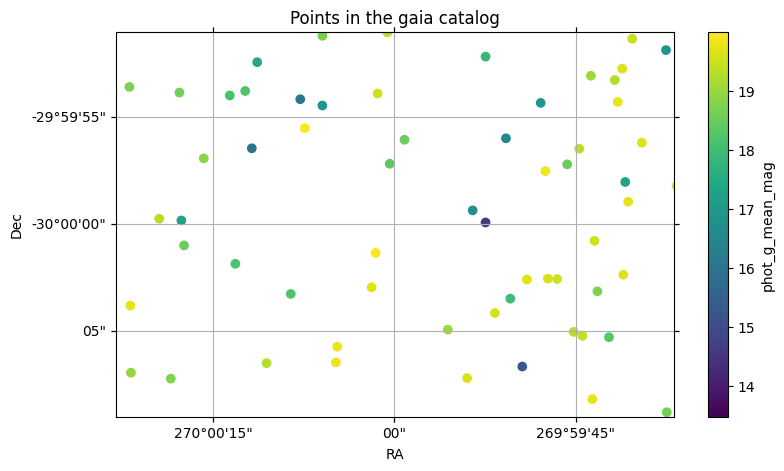

In [5]:
gaia.plot_points(fov=20 * u.arcsec, center=center, color_col="phot_g_mean_mag")

With this plot, we also see how a column can be used with a colormap to visualize the column values.


#### Multiple Plotting Calls

When multiple LSDB spatial plotting calls are called, they all plot to the same axes. The first call initializes the axes with the given WCS parameters, and any further calls reuse these same axes and parameters. If you want to plot on different axes or figures, you can call `plt.show()` between plotting calls, or pass the `ax` or `fig` parameters to plot on a specific axes or figure.

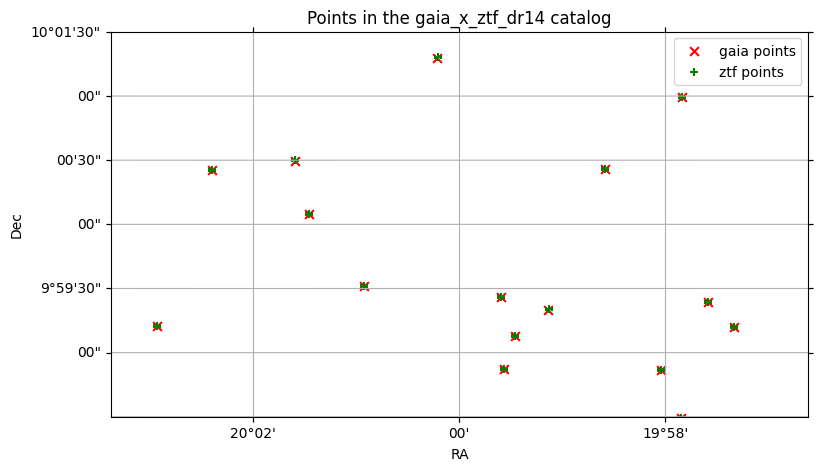

In [6]:
ztf = lsdb.read_hats('https://data.lsdb.io/hats/ztf_dr14/ztf_object', margin_cache='https://data.lsdb.io/hats/ztf_dr14/ztf_object_10arcs')
xmatched_cat = gaia.crossmatch(ztf)

xmatched_cat.plot_points(fov=200 * u.arcsec, center=SkyCoord(20 * u.deg, 10 * u.deg), c="red", marker="x", s=40, label="gaia points")
xmatched_cat.plot_points(ra_column="ra_ztf_dr14", dec_column="dec_ztf_dr14", c="green", marker='+', s=30, label="ztf points")
plt.legend()

By default, the catalog's main `ra` and `dec` columns are used to plot the points, but if there are multiple `ra` and `dec` columns, (for example, the right catalog in a crossmatch), these can be specified.

`plot_points` under the hood uses matplotlib's `scatter` function, so any keyword arguments that work with scatter will work with `plot_points`.

### Skymap: Plotting aggregations of data

The skymap function allows users to pass their own function to aggregate points in HEALPix pixels and plot them. For a simple example, to plot the number of points in each healpix pixel within a cone, you can do the following:

(<Figure size 1000x500 with 2 Axes>, <WCSAxes: >)

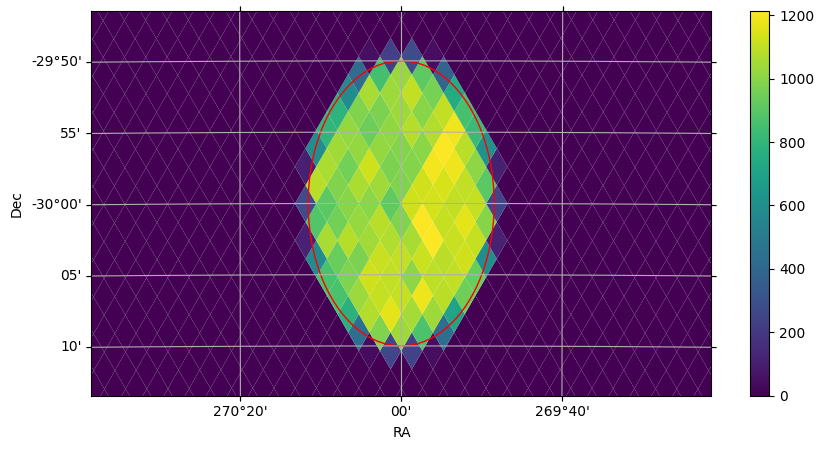

In [18]:
from lsdb import ConeSearch

cone_search = ConeSearch(center.ra.deg, center.dec.deg, 10 * 60)
gaia.search(cone_search).skymap(lambda x, _: len(x), order=11, plotting_args={"fov": (60 * u.arcmin, 30 * u.arcmin), "center":center})
cone_search.plot(fc="#00000000", ec="red")

In this case, we have a very simple lambda function to aggregate the data `lambda x, _: len(x)`. The user function for